In [1]:
%load_ext autoreload
import os
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important;}</style>"))

from core import *
from torch_backend import *

colors = ColorMap()

In [2]:
batch_norm = partial(BatchNorm, weight_init=None, bias_init=None)

def res_block(c_in, c_out, stride, **kw):
    block = {
        'bn1': batch_norm(c_in, **kw),
        'relu1': nn.ReLU(True),
        'branch': {
            'conv1': nn.Conv2d(c_in, c_out, kernel_size=3, stride=stride, padding=1, bias=False),
            'bn2': batch_norm(c_out, **kw),
            'relu2': nn.ReLU(True),
            'conv2': nn.Conv2d(c_out, c_out, kernel_size=3, stride=1, padding=1, bias=False),
        }
    }
    projection = (stride != 1) or (c_in != c_out)    
    if projection:
        block['conv3'] = (nn.Conv2d(c_in, c_out, kernel_size=1, stride=stride, padding=0, bias=False), ['relu1'])
    block['add'] =  (Add(), [('conv3' if projection else 'relu1'), 'branch/conv2'])
    return block

def DAWN_net(c=64, block=res_block, prep_bn_relu=False, concat_pool=True, **kw):    
    if isinstance(c, int):
        c = [c, 2*c, 4*c, 4*c]
        
    classifier_pool = {
        'in': Identity(),
        'maxpool': nn.MaxPool2d(4),
        'avgpool': (nn.AvgPool2d(4), ['in']),
        'concat': (Concat(), ['maxpool', 'avgpool']),
    } if concat_pool else {'pool': nn.MaxPool2d(4)}
    
    return {
        'input': (None, []),
        'prep': union({'conv': nn.Conv2d(3, c[0], kernel_size=3, stride=1, padding=1, bias=False)},
                      {'bn': batch_norm(c[0], **kw), 'relu': nn.ReLU(True)} if prep_bn_relu else {}),
        'layer1': {
            'block0': block(c[0], c[0], 1, **kw),
            'block1': block(c[0], c[0], 1, **kw),
        },
        'layer2': {
            'block0': block(c[0], c[1], 2, **kw),
            'block1': block(c[1], c[1], 1, **kw),
        },
        'layer3': {
            'block0': block(c[1], c[2], 2, **kw),
            'block1': block(c[2], c[2], 1, **kw),
        },
        'layer4': {
            'block0': block(c[2], c[3], 2, **kw),
            'block1': block(c[3], c[3], 1, **kw),
        },
        'final': union(classifier_pool, {
            'flatten': Flatten(),
            'linear': nn.Linear(2*c[3] if concat_pool else c[3], 10, bias=True),
        }),
        'logits': Identity(),
    }


def conv_bn(c_in, c_out, bn_weight_init=1.0, **kw):
    return {
        'conv': nn.Conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1, bias=False), 
        'bn': batch_norm(c_out, bn_weight_init=bn_weight_init, **kw), 
        'relu': nn.ReLU(True)
    }

def basic_net(channels, weight,  pool, **kw):
    return {
        'input': (None, []),
        'prep': conv_bn(3, channels['prep'], **kw),
        'layer1': dict(conv_bn(channels['prep'], channels['layer1'], **kw), pool=pool),
        'layer2': dict(conv_bn(channels['layer1'], channels['layer2'], **kw), pool=pool),
        'layer3': dict(conv_bn(channels['layer2'], channels['layer3'], **kw), pool=pool),
        'pool': nn.MaxPool2d(4),
        'flatten': Flatten(),
        'linear': nn.Linear(channels['layer3'], 10, bias=False),
        'logits': Mul(weight),
    }

def net(channels=None, weight=0.125, pool=nn.MaxPool2d(2), extra_layers=(), res_layers=('layer1', 'layer3'), **kw):
    channels = channels or {'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512}
    residual = lambda c, **kw: {'in': Identity(), 'res1': conv_bn(c, c, **kw), 'res2': conv_bn(c, c, **kw), 
                                'add': (Add(), ['in', 'res2/relu'])}
    n = basic_net(channels, weight, pool, **kw)
    for layer in res_layers:
        n[layer]['residual'] = residual(channels[layer], **kw)
    for layer in extra_layers:
        n[layer]['extra'] = conv_bn(channels[layer], channels[layer], **kw)       
    return n

remove_identity_nodes = lambda net: remove_by_type(net, Identity)

In [19]:
DATA_DIR = './data'
dataset = cifar10(DATA_DIR)
timer = Timer()
print('Preprocessing training data')
transforms = [
    partial(normalise, mean=np.array(cifar10_mean, dtype=np.float32), std=np.array(cifar10_std, dtype=np.float32)),
    partial(transpose, source='NHWC', target='NCHW'), 
]
train_set = list(zip(*preprocess(dataset['train'], [partial(pad, border=4)] + transforms).values()))
print(f'Finished in {timer():.2} seconds')
print('Preprocessing test data')
test_set = list(zip(*preprocess(dataset['valid'], transforms).values()))
print(f'Finished in {timer():.2} seconds')

batch_size = 512
test_batches = DataLoader(test_set, batch_size, shuffle=False, num_workers=0)
train_batches = DataLoader(train_set, batch_size, shuffle=False, num_workers=0)

Preprocessing training data
Finished in 1.4 seconds
Preprocessing test data
Finished in 0.063 seconds


In [4]:
def train(model, lr_schedule, train_set, test_set, batch_size, num_workers=0, save_location=None):
    train_batches = DataLoader(train_set, batch_size, shuffle=True, set_random_choices=True, num_workers=num_workers)
    test_batches = DataLoader(test_set, batch_size, shuffle=False, num_workers=num_workers)
    
    lr = lambda step: lr_schedule(step/len(train_batches))/batch_size
    opts = [SGD(trainable_params(model).values(), {'lr': lr, 'weight_decay': Const(5e-4*batch_size), 'momentum': Const(0.9)})]
    logs, state = Table(), {MODEL: model, LOSS: x_ent_loss, OPTS: opts}
    for epoch in range(lr_schedule.knots[-1]):
        logs.append(union({'epoch': epoch+1, 'lr': lr_schedule(epoch+1)}, 
                          train_epoch(state, Timer(torch.cuda.synchronize), train_batches, test_batches)))
        if save_location is not None:
            torch.save(model.state_dict(), f'{save_location}/epoch{epoch+1}.pt')
    return logs

In [5]:
# Reproducibility framework 
num_runs = 5
for run in range(num_runs):
    torch.manual_seed(run)
    lr_schedule = PiecewiseLinear([0, 15, 30, 35], [0, 0.44, 0.005, 0])
    batch_size = 512

    n = DAWN_net()
    model = Network(n).to(device).half()
    train_set_x = Transform(train_set, [Crop(32, 32), FlipLR()])
    
    # Check if this seed has been run already
    prefix = f'seed{run}'
    if os.path.exists(prefix):
        print(f'already ran {prefix}')
        continue
    else:
        print(f'running {prefix}')
        os.mkdir(prefix)
        torch.save(model.state_dict(), f'{prefix}/epoch0.pt')
        summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size, num_workers=0, save_location=prefix)

already ran seed0
already ran seed1
already ran seed2
already ran seed3
already ran seed4


In [5]:
model1 = Network(DAWN_net())
model1.load_state_dict(torch.load('epoch1.pt'))
model1.eval().to(device).half()

model35 = Network(DAWN_net())
model35.load_state_dict(torch.load('epoch35.pt'))
model35.eval().to(device).half()


# state1 = {MODEL: model1, LOSS: x_ent_loss}
# valid_summary = epoch_stats(reduce(test_batches, state1, default_valid_steps))
# valid_summary = epoch_stats(reduce(train_batches, state1, default_valid_steps))
# print(valid_summary)

# state35 = {MODEL: model35, LOSS: x_ent_loss}
# valid_summary = epoch_stats(reduce(test_batches, state35, default_valid_steps))
# valid_summary = epoch_stats(reduce(train_batches, state35, default_valid_steps))
# print(valid_summary)

test


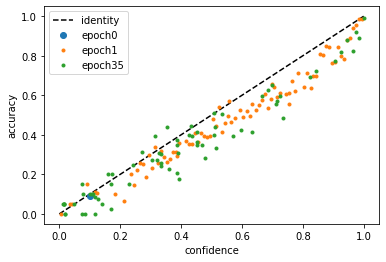

train


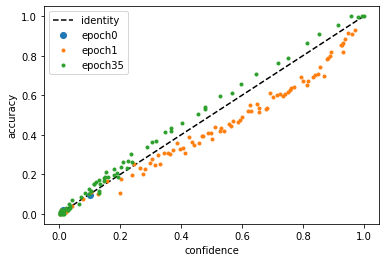

test


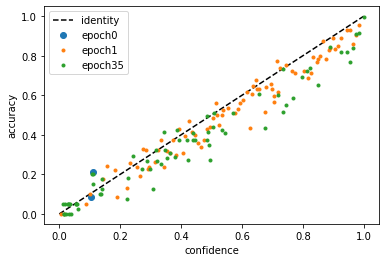

train


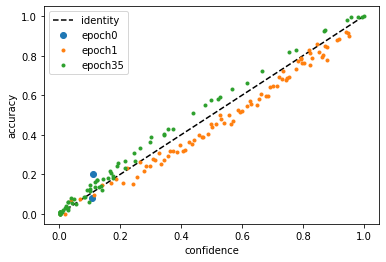

test


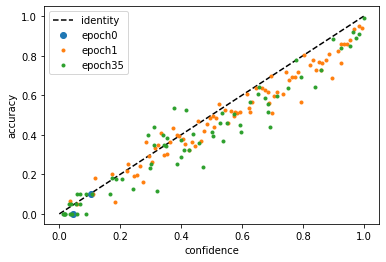

train


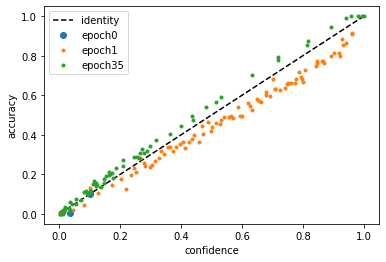

test


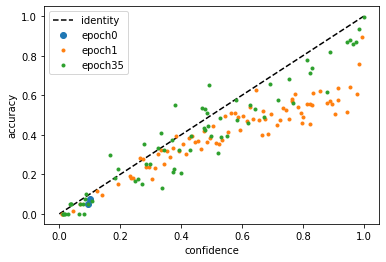

train


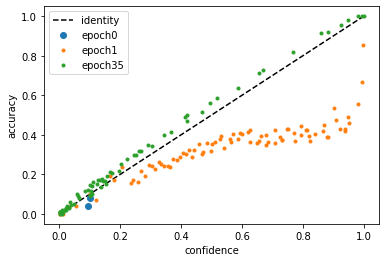

test


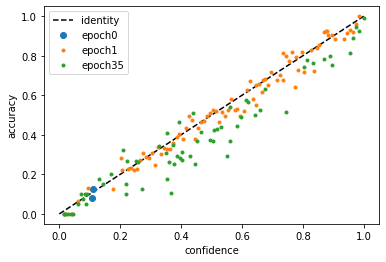

train


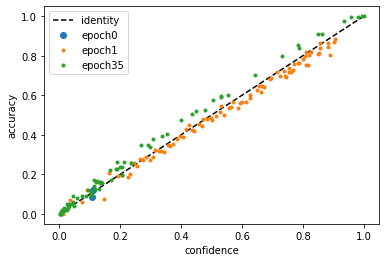

In [28]:
# Plot calibration by deciles
def check_logits(model, batch):
    if model.training:
        model.train(False)
    logits = model({'input': batch['input'].clone()})['logits'].detach()
    softmax = torch.nn.Softmax(dim=1)
    logits = softmax(logits)
    target = batch['target']
    return logits, target

def calib_counts(model, batches, buckets=10):
    quantiles = np.linspace(0, 1, buckets+1)[1:]
    avg_correct = np.zeros(buckets)
    avg_confidence = np.zeros(buckets)
    bucket_total = np.zeros(buckets)
    num_batches = 0
    for batch in batches:
        num_batches += 1
        logits, target = check_logits(model, batch)
        probs, preds = torch.max(logits, dim=1)
        for i in range(buckets):
            dec_probs = probs[probs <= quantiles[i]]
            dec_preds = preds[probs <= quantiles[i]]
            dec_target = target[probs <= quantiles[i]]
            bucket_total[i] += len(dec_target)
            if len(dec_target) > 0:
                avg_correct[i] += sum(dec_preds == dec_target) / len(dec_target)
                avg_confidence[i] += sum(dec_probs) / len(dec_target)
            
            preds = preds[probs > quantiles[i]]
            target = target[probs > quantiles[i]]
            probs = probs[probs > quantiles[i]]
    avg_correct = avg_correct / num_batches
    avg_confidence = avg_confidence / num_batches
    return avg_correct, avg_confidence, bucket_total
    
def calibration_curve(models, batches, labels, buckets=10, styles=['o']*len(models)):
    x = [0, 1]
    plt.figure()
    plt.plot(x, x, 'k--', label='identity')
    for i in range(len(models)):
        avg_correct, avg_confidence, bucket_total = calib_counts(models[i], batches, buckets=buckets)
        # Remove any buckets that are empty
        plt.plot(avg_confidence[bucket_total > 0], avg_correct[bucket_total > 0], styles[i], label=labels[i])
    plt.legend()
    plt.xlabel('confidence')
    plt.ylabel('accuracy')
    plt.show()
    
for run in range(5):
    prefix = f'seed{run}'
    models = []
    labels = ['epoch0', 'epoch1', 'epoch35']
    styles = ['o', '.', '.']
    for epoch in [0, 1, 35]:
        model = Network(DAWN_net())
        model.load_state_dict(torch.load(f'{prefix}/epoch{epoch}.pt'))
        model.eval().to(device).half()
        models.append(model)
    print('test')
    calibration_curve(models, test_batches, labels, buckets=100, styles=styles)
    print('train')
    calibration_curve(models, train_batches, labels, buckets=100, styles=styles)
    
# calibration_curve([model1, model35], test_batches, ['epoch1', 'epoch35'])


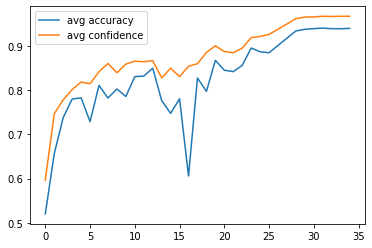

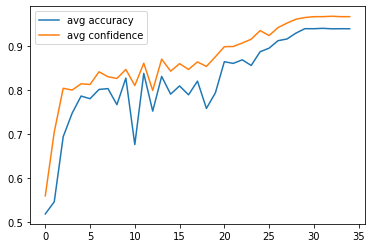

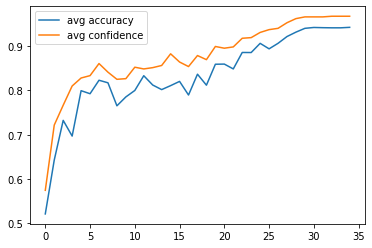

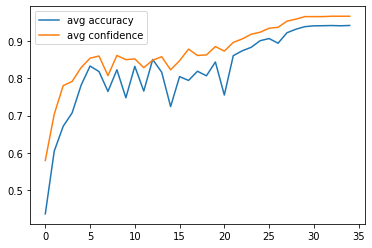

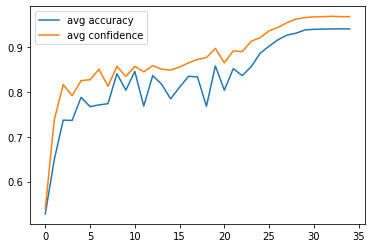

In [57]:
def check_logits(model, batch):
    if model.training:
        model.train(False)
    logits = model({'input': batch['input'].clone()})['logits'].detach()
    softmax = torch.nn.Softmax(dim=1)
    logits = softmax(logits)
    target = batch['target']
    return logits, target
    
def check_calibration(model):
    correct_fraction = 0
    avg_prob = 0
    num_batches = 0
    for batch in test_batches:
#     for batch in train_batches:
        num_batches += 1
        logits, target = check_logits(model, batch)
        probs, preds = torch.max(logits, dim=1)
        # Count how many times the prediction was correct vs the probability
        correct_fraction += sum(preds == target) / len(target)
        avg_prob += sum(probs) / len(target)
    correct_fraction = correct_fraction / num_batches
    avg_prob = avg_prob / num_batches
#     print(f'prediction was correct with probability {correct_fraction}, avg confidence was {avg_prob}')
    return correct_fraction, avg_prob

for run in range(5):
    prefix = f'seed{run}'
    correct_fracs = []
    avg_probs = []
    for epoch in range(35):
        model = Network(DAWN_net())
        model.load_state_dict(torch.load(f'{prefix}/epoch{epoch+1}.pt'))
        model.eval().to(device).half()
        correct_fraction, avg_prob = check_calibration(model)
        correct_fracs.append(correct_fraction)
        avg_probs.append(avg_prob)

    plt.figure()
    plt.plot(correct_fracs, label='avg accuracy')
    plt.plot(avg_probs, label='avg confidence')
    plt.legend()
# check_calibration(model1)
# check_calibration(model35)





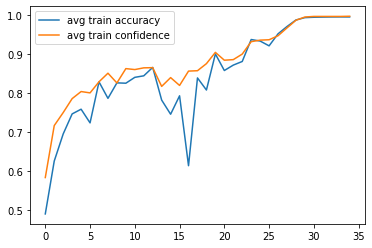

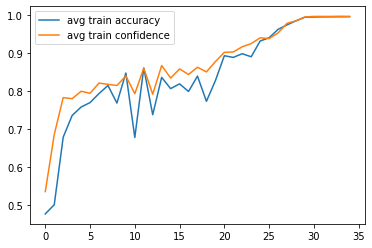

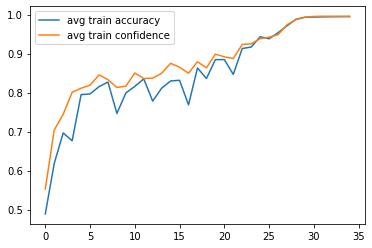

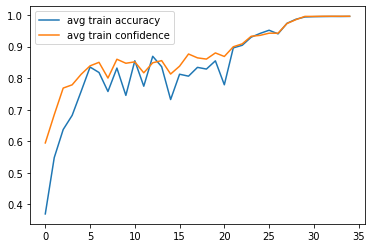

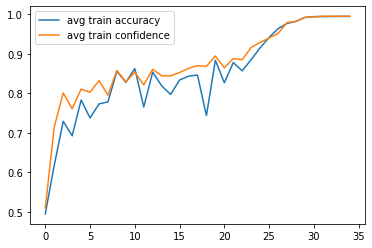

In [58]:
def check_logits(model, batch):
    if model.training:
        model.train(False)
    logits = model({'input': batch['input'].clone()})['logits'].detach()
    softmax = torch.nn.Softmax(dim=1)
    logits = softmax(logits)
    target = batch['target']
    return logits, target
    
def check_calibration(model):
    correct_fraction = 0
    avg_prob = 0
    num_batches = 0
#     for batch in test_batches:
    for batch in train_batches:
        num_batches += 1
        logits, target = check_logits(model, batch)
        probs, preds = torch.max(logits, dim=1)
        # Count how many times the prediction was correct vs the probability
        correct_fraction += sum(preds == target) / len(target)
        avg_prob += sum(probs) / len(target)
    correct_fraction = correct_fraction / num_batches
    avg_prob = avg_prob / num_batches
#     print(f'prediction was correct with probability {correct_fraction}, avg confidence was {avg_prob}')
    return correct_fraction, avg_prob

for run in range(5):
    prefix = f'seed{run}'
    correct_fracs = []
    avg_probs = []
    for epoch in range(35):
        model = Network(DAWN_net())
        model.load_state_dict(torch.load(f'{prefix}/epoch{epoch+1}.pt'))
        model.eval().to(device).half()
        correct_fraction, avg_prob = check_calibration(model)
        correct_fracs.append(correct_fraction)
        avg_probs.append(avg_prob)

    plt.figure()
    plt.plot(correct_fracs, label='avg train accuracy')
    plt.plot(avg_probs, label='avg train confidence')
    plt.legend()
# check_calibration(model1)
# check_calibration(model35)





Next steps:
- rerun with different random seeds and plot range of confidences and probabilities
- compare training loss and test loss at the end of each epoch
- check calibration after each epoch and plot